# Mining stock price prediction with LSTM

## Autores

Angel Jorge Salazar | Data Analytics @ Kobranzas SAC
* Correo: angel.jorge@unmsm.edu.pe
* Linkedin https://www.linkedin.com/in/angel-jorge-salazar-7b3bb614b/

Heydy Mayumy Carrasco Huaccha | Data Analytics @ CGR
* Correo: heydy.carrasco.huaccha@gmail.com
* Linkedin https://www.linkedin.com/in/heydy-mayumy-carrasco-huaccha-3876bb137/

![](https://www.aboutespanol.com/thmb/tucVaDrXW_EDVJ586lE3e-tZYJM=/2309x1299/filters:fill(auto,1)/bolsadelvalores-5ae6450b04d1cf003c23246f.jpg)

In [ ]:
# Importación de librerías a utilizar 

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd 
import numpy as np 
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Cargando los datos

In [ ]:
# Importamos data a utilizar
from google.colab import files 
dataset = files.upload()

In [ ]:
df = pd.read_csv("/content/Datos históricos BVN (4).csv", decimal=",")

'''
este es un cojunto de acciones de la empresa TESLA, que contiene
los datos de apertura, valor máximo, mínimo y cierra
'''

print(df.head())


        Fecha  Último  Apertura  Máximo  Mínimo    Vol.  % var.
0  11.06.2021   10.81     10.80   10.92   10.79   2,92K   0,09%
1  10.06.2021   10.80     10.64   10.90   10.61  76,43K   1,69%
2  09.06.2021   10.62     10.96   10.96   10.61  40,36K  -3,19%
3  08.06.2021   10.97     11.09   11.12   10.90  10,31K  -3,01%
4  07.06.2021   11.31     11.45   12.11   11.30  64,69K  -7,45%


In [ ]:
df = df["Último"].values
print(df)

[10.81 10.8  10.62 ... 17.31 17.2  17.94]


In [ ]:
#necesitamos que sea vector columna
df = df.reshape(-1,1)
print(df)

[[10.81]
 [10.8 ]
 [10.62]
 ...
 [17.31]
 [17.2 ]
 [17.94]]


In [ ]:
train_size = int(df.shape[0]*0.8)

data_train = np.array(df[:train_size])
data_test  = np.array(df[train_size:])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
data_train = scaler.fit_transform(data_train)
data_test = scaler.transform(data_test)   #Ojo: cambio_ fit_transform a transform

Necesitamos una función para preprocesar ese vector

In [ ]:
def generate_dataset (df):
  x = []
  y = []
  window_size = 50 # la ventana de días anterior que será usada para predecir 

  for i in range(window_size, df.shape[0]):
    x.append(df[i-window_size:i,0]) #definiendo nuestros 50 días previos 
    y.append(df[i,0])
  x = np.array(x)
  y = np.array(y)
  return x,y
  


Nuestras características x, son los 50 días previos. 


In [ ]:
x_train, y_train = generate_dataset(data_train)
x_test, y_test = generate_dataset(data_test)




Nuestra capa LSTM, necesita los datos en una matriz 3D. Tenemos que preparar nuestros datos para convertirlos en una matriz 3D y podamos usarlos con una capa LSTM 

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

Creando nuestro modelo de red

In [ ]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1],1)))
# Estamos inicializando nuestro modelo como secuencial con 96 neuronas en la dimensionalidad de salida. 
# Usamos return_sequences = True para hacer la capa LSTM con entrada tridimensional 
#input_shape es simplemente el formato de entrada de nuestro conjunto 

model.add(Dropout(0.2))
#Es la fracción de apagar neuronar al 20% en las capas. 

model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [ ]:
#compilar el modelo 

model.compile(loss="mean_squared_error", optimizer="adam")
# usamos mse porque es un problema de regresión y adam para actualizar los pesos de la red de forma iterativa. 


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50, 96)            37632     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 96)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50, 96)            74112     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 96)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 50, 96)            74112     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50, 96)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 96)               

In [ ]:
model.fit(x_train, y_train, epochs=38, batch_size=32) #epochs de 38, porque el loss ya no disminuye mas

Epoch 1/38
47/47 [==============================] - 5s 112ms/step - loss: 0.0030
Epoch 2/38
47/47 [==============================] - 5s 111ms/step - loss: 0.0034
Epoch 3/38
47/47 [==============================] - 5s 112ms/step - loss: 0.0031
Epoch 4/38
47/47 [==============================] - 5s 111ms/step - loss: 0.0028
Epoch 5/38
47/47 [==============================] - 5s 110ms/step - loss: 0.0031
Epoch 6/38
47/47 [==============================] - 5s 111ms/step - loss: 0.0027
Epoch 7/38
47/47 [==============================] - 5s 112ms/step - loss: 0.0026
Epoch 8/38
47/47 [==============================] - 5s 111ms/step - loss: 0.0027
Epoch 9/38
47/47 [==============================] - 5s 110ms/step - loss: 0.0027
Epoch 10/38
47/47 [==============================] - 5s 111ms/step - loss: 0.0031
Epoch 11/38
47/47 [==============================] - 5s 111ms/step - loss: 0.0025
Epoch 12/38
47/47 [==============================] - 5s 110ms/step - loss: 0.0026
Epoch 13/38
47/47 [======

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1))




Con 38 epochs

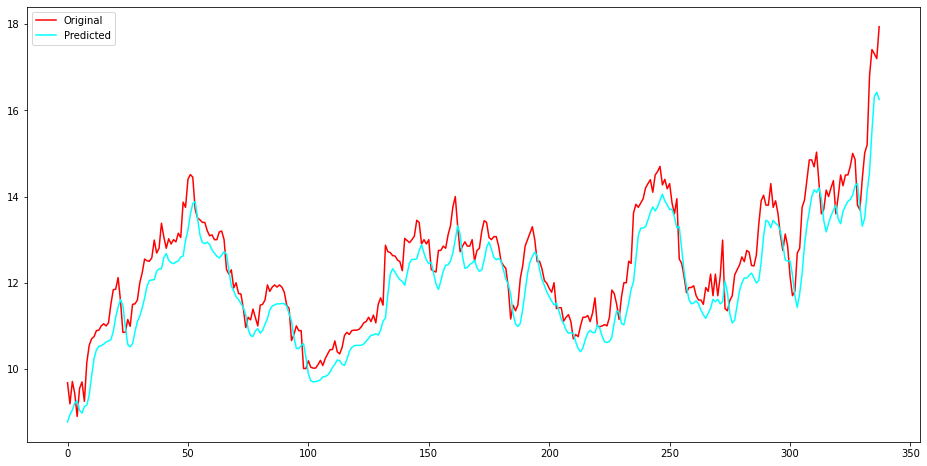

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(y_test_scaled, color='red', label='Original')
plt.plot(predictions, color='cyan', label='Predicted')
plt.legend()